In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import ensemble, tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from statsmodels.tools.eval_measures import rmse
import re

%matplotlib inline

In [49]:
sns.set(style='white', rc={'figure.figsize':(12,6)})

# Previously Cleaned/Engineered Data

In [3]:
craig_clean = pd.read_csv('craig_clean_wfeatures.csv')
craig_clean.head()

,city,price,year,manufacturer,make,condition,cylinders,fuel,odometer,title_status,...,pricey_state,is_auto_fwd,is_new,f250_pricey_state,stang_pricey_state,pricey_model,car_size_compact,car_size_full-size,car_size_mid-size,car_size_sub-compact
0,marshall,11900,2010.0,dodge,challengerse,good,6 cylinders,gas,43600.0,clean,...,0,0,0,0,0,0,0,0,0,0
1,marshall,2800,2004.0,ford,taurus,good,6 cylinders,gas,168591.0,clean,...,0,1,0,0,0,0,0,1,0,0
2,marshall,400,2001.0,NaN,2001grandprix,NaN,NaN,gas,217000.0,clean,...,0,0,0,0,0,0,0,0,0,0
3,marshall,9900,2007.0,gmc,yukon,good,8 cylinders,gas,169000.0,clean,...,0,0,0,0,0,0,0,0,0,0
4,marshall,12500,2015.0,jeep,patriothighaltitude,like new,4 cylinders,gas,39500.0,rebuilt,...,0,0,0,0,0,0,0,0,0,1


# Features

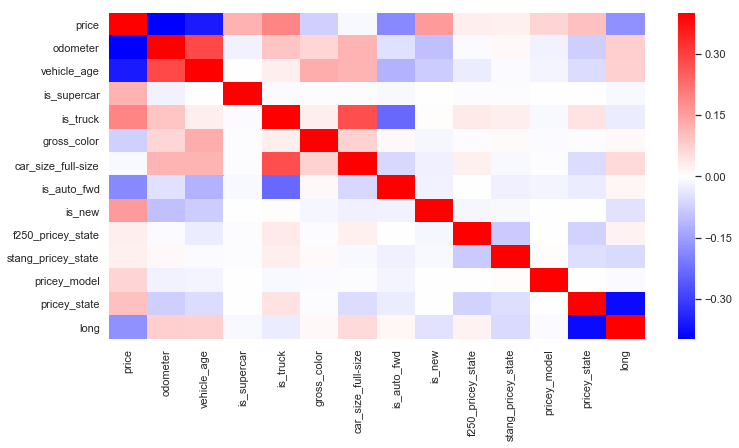

In [9]:
model_df = craig_clean.loc[:,['price',
                              'odometer',
                              'vehicle_age',
                              'is_supercar',
                              'is_truck',
                              'gross_color',
                              'car_size_full-size',
                              'is_auto_fwd',
                              'is_new',
                              'f250_pricey_state',
                              'stang_pricey_state',
                              'pricey_model',
                              'pricey_state',
                              'long'
                             ]]
#null_df = model_df.isnull().any() 
#print(null_df[null_df == True])
model_df.dropna(inplace=True)
sns.heatmap(model_df.corr(), cmap='bwr', center=0, vmax=0.4)
plt.show()

## Train Test Split

In [12]:
X = model_df.drop(['price'], axis=1)
Y = model_df['price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.35, random_state = 38)

print('The number of observations in training: {}'.format(len(X_train)))
print('The number of observations in test: {}'.format(len(X_test)))

s = StandardScaler()
X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

The number of observations in training: 743862
The number of observations in test: 400542


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()


# Modelling

## Decision Tree

In [41]:
dtree = tree.DecisionTreeRegressor(
    max_depth=10,
    min_samples_leaf=100,
    max_features=3,
    random_state=98345
)

dtree.fit(X_train, Y_train)
Y_train_pred = dtree.predict(X_train)
print(dtree.score(X_train, Y_train))
print(rmse(Y_train, Y_train_pred))
print(dtree.feature_importances_)

0.49007444911574355
8376.056830646636
[0.47474397 0.32816135 0.         0.05144263 0.00242886 0.00289378
 0.07520563 0.00065972 0.00306079 0.00068445 0.         0.02078739
 0.03993144]


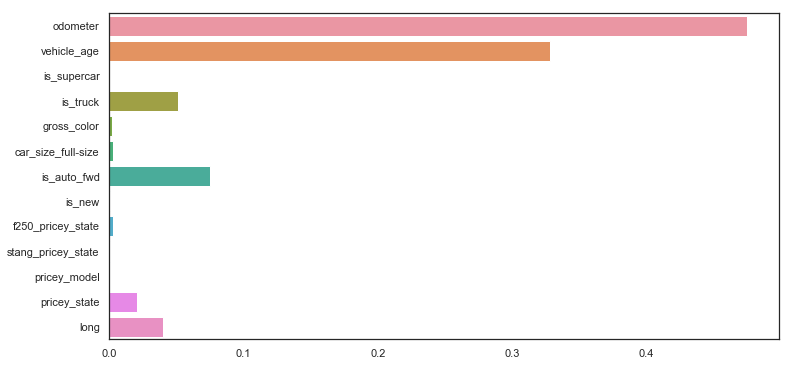

[(0.47474396781522055, 'odometer'), (0.32816135340716857, 'vehicle_age'), (0.0752056273667144, 'is_auto_fwd'), (0.05144262556829897, 'is_truck'), (0.03993143657353665, 'long'), (0.02078738767856179, 'pricey_state'), (0.0030607924792198826, 'f250_pricey_state'), (0.0028937822726984087, 'car_size_full-size'), (0.0024288607990601307, 'gross_color'), (0.0006844459186857964, 'stang_pricey_state'), (0.0006597201208347732, 'is_new'), (0.0, 'pricey_model'), (0.0, 'is_supercar')]


In [53]:
feat_imp = zip(dtree.feature_importances_, X.columns)
feat_imp = list(feat_imp)


sns.barplot(
    x=dtree.feature_importances_,
    y=X.columns
)
plt.show()
print(sorted(feat_imp, reverse=True))

In [30]:
dtree = tree.DecisionTreeRegressor()
params = {
    'max_depth':Integer(1,10),
    'min_samples_leaf':Integer(100,700),
    'max_features':Integer(1,13)
}

opt = BayesSearchCV(
    dtree,
    params,
    cv=5,
    n_iter=10
)

opt.fit(X_train, Y_train)
y_train_pred = opt.predict(X_train)
print(opt.score(X_train, Y_train))
print(rmse(Y_train, Y_train_pred))
print(opt.best_params_)

0.5279101340863586
8376.056830646636
{'max_depth': 7, 'max_features': 12, 'min_samples_leaf': 213}


## Random Forest

In [31]:
rfr = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    max_features=3,
    min_samples_leaf=100,
    random_state=832
)

rfr.fit(X_train, Y_train)
Y_train_pred = rfr.predict(X_train)
print(rfr.score(X_train, Y_train))
print(rmse(Y_train, Y_train_pred))
print(rfr.feature_importances_)

0.5458092369391216
7905.063761922112
[2.90736251e-01 4.80941994e-01 3.93679555e-03 7.23695676e-02
 2.45514452e-03 4.08819087e-03 7.92335143e-02 2.20911824e-02
 1.94704211e-03 4.30973682e-04 2.19687575e-03 3.26426194e-03
 3.63082062e-02]


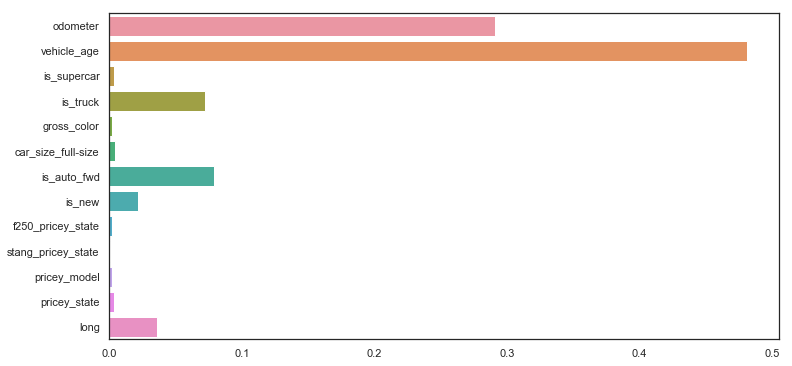

[(0.48094199412814476, 'vehicle_age'), (0.290736251012008, 'odometer'), (0.07923351425697994, 'is_auto_fwd'), (0.07236956763511436, 'is_truck'), (0.03630820617539559, 'long'), (0.022091182371743047, 'is_new'), (0.004088190870784298, 'car_size_full-size'), (0.003936795547737872, 'is_supercar'), (0.0032642619371897885, 'pricey_state'), (0.002455144518622892, 'gross_color'), (0.0021968757529971946, 'pricey_model'), (0.001947042111286613, 'f250_pricey_state'), (0.00043097368199554773, 'stang_pricey_state')]


In [54]:
feat_imp = zip(rfr.feature_importances_, X.columns)
feat_imp = list(feat_imp)

sns.barplot(
    x=rfr.feature_importances_,
    y=X.columns
)
plt.show()
print(sorted(feat_imp, reverse=True))

# Conclusion

Based on the models above, the Random Forest does perform slightly better than a tuned decision tree. If runtime was no concern or issue then a hyperparameter tuned Random Forest would perform better than the normal Random Forest or tuned decision tree. Both models have similar importance rankings for each of the features. It looks like the random forest model is giving more weight to the 'is_new' category and the is_supercar category. This features importance could be enhanced by allowing less samples per leaf as the total number of supercars is low in the dataset.
 
 It will be useful in future iterations to add more features and look at how well the models are performing in subsets of the data to identify areas to focus feature engineering.